##### Copyright 2022 The TensorFlow GNN Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learning shortest paths with GraphNetworks in TF-GNN

Forked from [graph_nets library](https://github.com/deepmind/graph_nets) example ["shortest path demo"](https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/shortest_path.ipynb).

<table class="tfo-notebook-buttons" align="left">
  <td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/gnn/blob/master/examples/notebooks/graph_network_shortest_path.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/gnn/blob/main/examples/notebooks/graph_network_shortest_path.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
</table>

### Task description
Given:
* a graph representing some cities
* some edges representing roads connecting the cities
* a "start" and an "end" city

the task consists of finding the shortest path that connect the "start" and "end" cities.

### Model description

The model performs message pasing using a`GraphNetwork` as defined in:

"[Relational inductive biases, deep learning, and graph networks](https://arxiv.org/abs/1806.01261 )" Battaglia et al., arXiv 2018.

The deep graph neural network used is built similarly to the `EncodeProcessDecode` architecture as defined in:

"[Learning to Simulate Complex Physics with Graph Networks](https://arxiv.org/abs/2002.09405)" Sanchez-Gonzalez et al., ICML 2020.

where the `InteractionNetwork`s are replaced by `GraphNetwork`s, to allow global
updates.

This `EncodeProcessDecode` model is general purpose and can be used for any
node, edge, and/or context prediction task.

### Model training

For simplitity we train the model to predict a binary output for each city (binary node classification) and for each road (binary edge classification), indicating whether they are in the shortest path or not. The model trains to almost perfect accuracy in a few thousand training steps.



In [ ]:
# @title Installing TF-GNN. { form-width: "30%" }

!pip install -q tensorflow-gnn || echo "Ignoring version conflicts, continuing..."

In [1]:
# @title Imports. { form-width: "30%" }

import collections
import functools
import itertools
from typing import Callable, Optional, Mapping, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import signal
from scipy import spatial
import tensorflow as tf
import tensorflow_gnn as tfgnn

In [2]:
# @title GNN architectures. { form-width: "30%" }

def GraphNetworkGraphUpdate(
    *,
    edges_next_state_factory: Callable[..., tf.keras.layers.Layer],
    nodes_next_state_factory: Callable[..., tf.keras.layers.Layer],
    context_next_state_factory: Optional[Callable[..., tf.keras.layers.Layer]],
    receiver_tag: Optional[tfgnn.IncidentNodeTag] = tfgnn.TARGET,
    reduce_type_to_nodes: str = "sum",
    reduce_type_to_context: str = "sum",
    use_input_context_state: bool = True,
    name: str = "graph_network"):
  """Returns a GraphUpdate to run a GraphNetwork on all node sets and edge sets.

  The returned layer implements a Graph Network, as described by
  Battaglia et al.: ["Relational inductive biases, deep learning, and
  graph networks"](https://arxiv.org/abs/1806.01261), 2018, generalized
  to heterogeneous graphs.

  It expects an input GraphTensor with a `tfgnn.HIDDEN_STATE` feature on all
  node sets and edge sets, and also context if `use_input_context_state=True`.
  It runs edge, node, and context updates, in this order, separately for each
  edge set, node set (regardless whether it has an incoming edge set), and also
  context if `context_next_state_factory` is set. Finally, it returns a
  GraphTensor with updated hidden states, incl. a context state, if
  `context_next_state_factory` is set.

  The model can also behave as an Interaction Network ([Battaglia et al., NIPS
  2016](https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html))
  by setting
    * `use_input_context_state = False`
    * `context_next_state_factory = None`

  Args:
    edges_next_state_factory: Called with keyword argument `edge_set_name=`
      for each edge set to return the NextState layer for use in the respective
      `tfgnn.keras.layers.EdgeSetUpdate`.
    nodes_next_state_factory: Called with keyword argument `node_set_name=`
      for each node set to return the NextState layer for use in the respective
      `tfgnn.keras.layers.NodeSetUpdate`.
    context_next_state_factory: If set, a `tfgnn.keras.layers.ContextUpdate`
      is included with the NextState layer returned by calling this factory.
    receiver_tag: The incident node tag at which each edge set is used to
      update node sets. Defaults to `tfgnn.TARGET`.
    reduce_type_to_nodes: Controls how incident edges at a node are aggregated
      within each EdgeSet. Defaults to `"sum"`. (The aggregates of the various
      incident EdgeSets are then concatenated.)
    reduce_type_to_context: Controls how the nodes of a NodeSet or the edges of
      an EdgeSet are aggregated for the context update. Defaults to `"sum"`.
      (The aggregates of the various NodeSets/EdgeSets are then concatenated.)
    use_input_context_state: If true, the input `GraphTensor.context` must have
      a `tfgnn.HIDDEN_STATE` feature that gets used as input in all edge, node
      and context updates.
    name: A name for the returned layer.
  """
  def deferred_init_callback(graph_spec):
    context_input_feature = (
        tfgnn.HIDDEN_STATE if use_input_context_state else None)

    # To keep track node types that receive each edge type.
    incoming_edge_sets = collections.defaultdict(list)

    # For every edge set, create an EdgeSetUpdate.
    edge_set_updates = {}
    for edge_set_name in sorted(graph_spec.edge_sets_spec.keys()):
      next_state = edges_next_state_factory(edge_set_name=edge_set_name)
      edge_set_updates[edge_set_name] = tfgnn.keras.layers.EdgeSetUpdate(
          next_state=next_state,
          edge_input_feature=tfgnn.HIDDEN_STATE,
          node_input_feature=tfgnn.HIDDEN_STATE,
          context_input_feature=context_input_feature)
      # Keep track of which node set is the receiver for this edge type
      # as we will need it later.
      target_name = graph_spec.edge_sets_spec[
          edge_set_name].adjacency_spec.node_set_name(receiver_tag)
      incoming_edge_sets[target_name].append(edge_set_name)

    # For every node set, create a NodeSetUpdate.
    node_set_updates = {}
    for node_set_name in sorted(graph_spec.node_sets_spec.keys()):
      # Apply a node update, after summing *all* of the received edges
      # for that node set.
      next_state = nodes_next_state_factory(node_set_name=node_set_name)
      node_set_updates[node_set_name] = tfgnn.keras.layers.NodeSetUpdate(
          next_state=next_state,
          edge_set_inputs={
              edge_set_name: tfgnn.keras.layers.Pool(
                  receiver_tag, reduce_type_to_nodes,
                  feature_name=tfgnn.HIDDEN_STATE)
              for edge_set_name in incoming_edge_sets[node_set_name]},
          node_input_feature=tfgnn.HIDDEN_STATE,
          context_input_feature=context_input_feature)

    # Create a ContextUpdate, if requested.
    context_update = None
    if context_next_state_factory is not None:
      next_state = context_next_state_factory()
      context_update = tfgnn.keras.layers.ContextUpdate(
          next_state=next_state,
          edge_set_inputs={
              edge_set_name: tfgnn.keras.layers.Pool(
                  tfgnn.CONTEXT, reduce_type_to_context,
                  feature_name=tfgnn.HIDDEN_STATE)
              for edge_set_name in sorted(graph_spec.edge_sets_spec.keys())},
          node_set_inputs={
              node_set_name: tfgnn.keras.layers.Pool(
                  tfgnn.CONTEXT, reduce_type_to_context,
                  feature_name=tfgnn.HIDDEN_STATE)
              for node_set_name in sorted(graph_spec.node_sets_spec.keys())},
          context_input_feature=context_input_feature)
    return dict(edge_sets=edge_set_updates,
                node_sets=node_set_updates,
                context=context_update)

  return tfgnn.keras.layers.GraphUpdate(
      deferred_init_callback=deferred_init_callback, name=name)


def build_mlp(num_hidden_layers: int,
              hidden_size: int,
              output_size: int,
              use_layer_norm: bool,
              activation: str = "relu",
              activate_final: bool = False,
              name: str = "mlp"):
  """Builds an MLP."""
  output_sizes = [hidden_size] * num_hidden_layers + [output_size]
  mlp = tf.keras.Sequential(name="mlp")
  for layer_i, size in enumerate(output_sizes):
    layer_activation = activation
    if not activate_final and layer_i == len(output_sizes) - 1:
      layer_activation = None
    mlp.add(tf.keras.layers.Dense(
        size,
        activation=layer_activation,
        use_bias=True,
        kernel_initializer="variance_scaling",
        bias_initializer="zeros",
        name=f"{name}/dense_{layer_i}"))
  if use_layer_norm:
    mlp.add(tf.keras.layers.LayerNormalization(
        name=f"{name}/layer_norm"))
  return mlp


class EncodeProcessDecode(tf.keras.layers.Layer):
  """Implements EncodeProcessDecode from https://arxiv.org/abs/2002.09405.

  It is extended to:
  * run with global updates.
  * use shared or unshared weights when using message passing.
  * produce per node, per edge and/or context outputs.

  It requires node sets, edge sets and context with the
  `tfgnn.HIDDEN_STATE` feature.
  """
  def __init__(
      self,
      edge_output_size: Optional[int],
      node_output_size: Optional[int],
      context_output_size: Optional[int],
      num_message_passing_steps: int,
      num_mlp_hidden_layers: int,
      mlp_hidden_size: int,
      latent_size: int,
      use_layer_norm: bool,
      shared_processors: bool,
      reduce_type_to_nodes: str = "sum",
      reduce_type_to_context: str = "sum",
      name: str = "encode_process_decode"):
    super().__init__(name=name)

    # Build graph encoder.
    def encoder_fn(graph_piece, *, edge_set_name=None, node_set_name=None):
      piece_name = (f"edges_{edge_set_name}" if edge_set_name else
                    f"nodes_{node_set_name}" if node_set_name else "context")
      mlp = build_mlp(num_hidden_layers=num_mlp_hidden_layers,
                      hidden_size=mlp_hidden_size,
                      output_size=latent_size,
                      use_layer_norm=use_layer_norm,
                      name=f"{self.name}/encoder/{piece_name}")
      return mlp(graph_piece[tfgnn.HIDDEN_STATE])

    self._encoder = tfgnn.keras.layers.MapFeatures(
        edge_sets_fn=encoder_fn, node_sets_fn=encoder_fn, context_fn=encoder_fn)

    # Build graph processor(s).
    # We will just concatenate all inputs to each edge update, node update
    # and context upcate, and run an MLP on it.

    def processor_fn(*, processor_name, edge_set_name=None, node_set_name=None):
      if edge_set_name is not None:
        mlp_name = f"{processor_name}/edges_{edge_set_name}"
      elif node_set_name is not None:
        mlp_name = f"{processor_name}/nodes_{node_set_name}"
      else:
        mlp_name = f"{processor_name}/context"
      mlp = build_mlp(name=mlp_name,
                      num_hidden_layers=num_mlp_hidden_layers,
                      hidden_size=mlp_hidden_size,
                      output_size=latent_size,
                      use_layer_norm=use_layer_norm)
      return tfgnn.keras.layers.NextStateFromConcat(mlp)

    num_processors = (1 if shared_processors else num_message_passing_steps)

    processors = []
    for processor_i in range(num_processors):
      processor_name = f"{self.name}/processor_{processor_i}"
      processor_fn_named = functools.partial(processor_fn,
                                             processor_name=processor_name)
      processors.append(GraphNetworkGraphUpdate(
          edges_next_state_factory=processor_fn_named,
          nodes_next_state_factory=processor_fn_named,
          context_next_state_factory=processor_fn_named,
          reduce_type_to_nodes=reduce_type_to_nodes,
          reduce_type_to_context=reduce_type_to_context,
          name=processor_name))

    if shared_processors:
      self._processors = processors * num_message_passing_steps
    else:
      self._processors = processors

    # Build graph decoder.
    def decoder_fn(graph_piece, *, edge_set_name=None, node_set_name=None):
      piece_name = (f"edges_{edge_set_name}" if edge_set_name else
                    f"nodes_{node_set_name}" if node_set_name else "context")
      if edge_set_name:
        output_size = edge_output_size
      elif node_set_name:
        output_size = node_output_size
      else:
        output_size = context_output_size
      mlp = build_mlp(num_hidden_layers=num_mlp_hidden_layers,
                      hidden_size=mlp_hidden_size,
                      output_size=output_size,
                      use_layer_norm=False,  # Never LayerNorm for the outputs.
                      name=f"{self.name}/decoder/{piece_name}")
      return mlp(graph_piece[tfgnn.HIDDEN_STATE])

    self._decoder = tfgnn.keras.layers.MapFeatures(
        edge_sets_fn=decoder_fn if edge_output_size else None,
        node_sets_fn=decoder_fn if node_output_size else None,
        context_fn=decoder_fn if context_output_size else None)

  def call(self, input_graph: tfgnn.GraphTensor) -> tfgnn.GraphTensor:
    latent_graph = self._encoder(input_graph)
    for processor in self._processors:
      residual_graph = processor(latent_graph)
      latent_graph = sum_graphs(residual_graph, latent_graph)
    output_graph = self._decoder(latent_graph)
    return output_graph

In [3]:
# @title Utils for GraphTensor. { form-width: "30%" }

# TODO(b/234563300): Consider supporting `MapFeatures` for multiple graphs.
def sum_graphs(graph_1: tfgnn.GraphTensor, graph_2: tfgnn.GraphTensor,
               ) ->  tfgnn.GraphTensor:
  """Sums all features in two identical graphs."""
  assert set(graph_1.edge_sets.keys()) == set(graph_2.edge_sets.keys())
  new_edge_set_features = {}
  for set_name in graph_1.edge_sets.keys():
    new_edge_set_features[set_name] = _sum_feature_dict(
        graph_1.edge_sets[set_name].get_features_dict(),
        graph_2.edge_sets[set_name].get_features_dict())

  assert set(graph_1.node_sets.keys()) == set(graph_2.node_sets.keys())
  new_node_set_features = {}
  for set_name in graph_1.node_sets.keys():
    new_node_set_features[set_name] = _sum_feature_dict(
        graph_1.node_sets[set_name].get_features_dict(),
        graph_2.node_sets[set_name].get_features_dict())

  new_context_features = _sum_feature_dict(
      graph_1.context.get_features_dict(),
      graph_2.context.get_features_dict())
  return graph_1.replace_features(
      edge_sets=new_edge_set_features,
      node_sets=new_node_set_features,
      context=new_context_features)


def _sum_feature_dict(
    features_1: Mapping[str, tf.Tensor],
    features_2: Mapping[str, tf.Tensor]
    ) -> Mapping[str, tf.Tensor]:
  tf.nest.assert_same_structure(features_1, features_2)
  return tf.nest.map_structure(lambda x, y: x + y, features_1, features_2)


def nest_to_numpy(nest):
  return tf.nest.map_structure(lambda x: x.numpy(), nest)

# TODO(b/205123804): Provide a library function for this.
def graph_tensor_spec_from_sample_graph(sample_graph):
  """Build variable node/edge spec given a sample graph without batch axes."""
  tfgnn.check_scalar_graph_tensor(sample_graph)
  sample_graph_spec = sample_graph.spec
  node_sets_spec = {}
  for node_set_name, node_set_spec in sample_graph_spec.node_sets_spec.items():
    new_features_spec = {}
    for feature_name, feature_spec in node_set_spec.features_spec.items():
      new_features_spec[feature_name] = _to_none_leading_dim(feature_spec)
    node_sets_spec[node_set_name] = tfgnn.NodeSetSpec.from_field_specs(
        features_spec=new_features_spec,
        sizes_spec=tf.TensorSpec(shape=(1,), dtype=tf.int32))

  edge_sets_spec = {}
  for edge_set_name, edge_set_spec in sample_graph_spec.edge_sets_spec.items():
    new_features_spec = {}
    for feature_name, feature_spec in edge_set_spec.features_spec.items():
      new_features_spec[feature_name] = _to_none_leading_dim(feature_spec)

    adjacency_spec = tfgnn.AdjacencySpec.from_incident_node_sets(
        source_node_set=edge_set_spec.adjacency_spec.source_name,
        target_node_set=edge_set_spec.adjacency_spec.target_name,
        index_spec=_to_none_leading_dim(edge_set_spec.adjacency_spec.target))

    edge_sets_spec[edge_set_name] = tfgnn.EdgeSetSpec.from_field_specs(
        features_spec=new_features_spec,
        sizes_spec=tf.TensorSpec(shape=(1,), dtype=tf.int32),
        adjacency_spec=adjacency_spec)

  context_spec = sample_graph_spec.context_spec

  return tfgnn.GraphTensorSpec.from_piece_specs(
      node_sets_spec=node_sets_spec,
      edge_sets_spec=edge_sets_spec,
      context_spec=context_spec,
  )

def _to_none_leading_dim(spec):
  new_shape = list(spec.shape)
  new_shape[0] = None
  return tf.TensorSpec(shape=new_shape, dtype=spec.dtype)

In [4]:
# @title Defining the shortest path task. { form-width: "30%" }

def generate_task_graph(
    random_state,
    num_nodes_min_max: Tuple[int, int],
    dimensions: int = 2,
    theta: float = 1000.0,
    min_length: int = 1,
    rate: float = 1.0) -> tfgnn.GraphTensor:
  """Creates a connected graph.

  The graphs are geographic threshold graphs, but with added edges via a
  minimum spanning tree algorithm, to ensure all nodes are connected.

  Args:
    random_state: A random seed for the graph generator. Default= None.
    num_nodes_min_max: A sequence [lower, upper) number of nodes per graph.
    dimensions: (optional) An `int` number of dimensions for the positions.
      Default= 2.
    theta: (optional) A `float` threshold parameters for the geographic
      threshold graph's threshold. Large values (1000+) make mostly trees. Try
      20-60 for good non-trees. Default=1000.0.
    min_length: (optional) An `int` minimum number of edges in the shortest
      path. Default= 1.
    rate: (optional) A rate parameter for the node weight exponential sampling
      distribution. Default= 1.0.

  Returns:
    The graph.
  """
  graph = _generate_base_graph(
      random_state, num_nodes_min_max=num_nodes_min_max, dimensions=dimensions,
      theta=theta, rate=rate)
  graph = _add_shortest_path(random_state, graph, min_length=min_length)
  return _convert_to_graph_tensor(graph)


def task_graph_generator(random_seed: int, **task_kwargs):
  random_state = np.random.RandomState(random_seed)
  while True:
    yield generate_task_graph(random_state, **task_kwargs)


def get_dataset(random_seed: int, **task_kwargs):
  def generator_fn():
    return task_graph_generator(random_seed, **task_kwargs)
  graph_spec = graph_tensor_spec_from_sample_graph(next(generator_fn()))
  return tf.data.Dataset.from_generator(
      generator_fn, output_signature=graph_spec)


def _generate_base_graph(rand,
                         num_nodes_min_max,
                         dimensions,
                         theta,
                         rate):
  """Generates the base graph for the task."""
  # Sample num_nodes.
  num_nodes = rand.randint(*num_nodes_min_max)

  # Create geographic threshold graph.
  pos_array = rand.uniform(size=(num_nodes, dimensions))
  pos = dict(enumerate(pos_array))
  weight = dict(enumerate(rand.exponential(rate, size=num_nodes)))
  geo_graph = nx.geographical_threshold_graph(
      num_nodes, theta, pos=pos, weight=weight)

  # Create minimum spanning tree across geo_graph's nodes.
  distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))
  i_, j_ = np.meshgrid(range(num_nodes), range(num_nodes), indexing="ij")
  weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
  mst_graph = nx.Graph()
  mst_graph.add_weighted_edges_from(weighted_edges, weight="weight")
  mst_graph = nx.minimum_spanning_tree(mst_graph, weight="weight")
  # Put geo_graph's node attributes into the mst_graph.
  for i in mst_graph.nodes():
    mst_graph.nodes[i].update(geo_graph.nodes[i])

  # Compose the graphs.
  combined_graph = nx.compose_all((mst_graph, geo_graph.copy()))
  # Put all distance weights into edge attributes.
  for i, j in combined_graph.edges():
    combined_graph.get_edge_data(i, j).setdefault("weight",
                                                  distances[i, j])
  return combined_graph


def _pairwise(iterable):
  """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b)


def _set_diff(seq0, seq1):
  """Return the set difference between 2 sequences as a list."""
  return list(set(seq0) - set(seq1))


def _add_shortest_path(rand, graph, min_length=1):
  """Samples a shortest path in the graph."""
  # Map from node pairs to the length of their shortest path.
  pair_to_length_dict = {}
  lengths = list(nx.all_pairs_shortest_path_length(graph))
  for x, yy in lengths:
    for y, l in yy.items():
      if l >= min_length:
        pair_to_length_dict[x, y] = l
  if max(pair_to_length_dict.values()) < min_length:
    raise ValueError("All shortest paths are below the minimum length")
  # The node pairs which exceed the minimum length.
  node_pairs = list(pair_to_length_dict)

  # Computes probabilities per pair, to enforce uniform sampling of each
  # shortest path lengths.
  # The counts of pairs per length.
  counts = collections.Counter(pair_to_length_dict.values())
  prob_per_length = 1.0 / len(counts)
  probabilities = [
      prob_per_length / counts[pair_to_length_dict[x]] for x in node_pairs
  ]

  # Choose the start and end points.
  i = rand.choice(len(node_pairs), p=probabilities)
  start, end = node_pairs[i]
  path = nx.shortest_path(
      graph, source=start, target=end, weight="length")

  # Creates a directed graph, to store the directed path from start to end.
  digraph = graph.to_directed()

  # Add the "start", "end", and "solution" attributes to the nodes and edges.
  digraph.add_node(start, is_start=True)
  digraph.add_node(end, is_end=True)
  digraph.add_nodes_from(_set_diff(digraph.nodes(), [start]), is_start=False)
  digraph.add_nodes_from(_set_diff(digraph.nodes(), [end]), is_end=False)
  digraph.add_nodes_from(_set_diff(digraph.nodes(), path), is_in_path=False)
  digraph.add_nodes_from(path, is_in_path=True)
  path_edges = list(_pairwise(path))
  digraph.add_edges_from(_set_diff(digraph.edges(), path_edges), is_in_path=False)
  digraph.add_edges_from(path_edges, is_in_path=True)

  return digraph


def _convert_to_graph_tensor(graph_nx):
  """Converts the graph to a GraphTensor."""
  number_of_nodes = graph_nx.number_of_nodes()
  nodes_data = [data for _, data in graph_nx.nodes(data=True)]
  node_features = tf.nest.map_structure(
      lambda *n: np.stack(n, axis=0), *nodes_data)

  number_of_edges = graph_nx.number_of_edges()
  source_indices, target_indices, edges_data = zip(*graph_nx.edges(data=True))
  source_indices = np.array(source_indices, dtype=np.int32)
  target_indices = np.array(target_indices, dtype=np.int32)
  edge_features = tf.nest.map_structure(
      lambda *e: np.stack(e, axis=0), *edges_data)
  context_features = dict(graph_nx.graph)
  return tfgnn.GraphTensor.from_pieces(
      node_sets={
          "cities": tfgnn.NodeSet.from_fields(
              sizes=[number_of_nodes],
              features=node_features,
              )},
      edge_sets={
          "roads": tfgnn.EdgeSet.from_fields(
              sizes=[number_of_edges],
              features=edge_features,
              adjacency=tfgnn.Adjacency.from_indices(
                  source=("cities", source_indices),
                  target=("cities", target_indices))
              )},
      context=tfgnn.Context.from_fields(features=context_features),
      )

def draw_graph(ax, task_graph):

  tfgnn.check_scalar_graph_tensor(task_graph)
  assert task_graph.num_components == 1

  ax.set_xticks([])
  ax.set_yticks([])
  node_set = task_graph.node_sets["cities"]
  node_positions = node_set["pos"].numpy()

  start_node_mask = node_set["is_start"].numpy()
  end_node_mask = node_set["is_end"].numpy()
  other_nodes_mask = ~ (start_node_mask + end_node_mask)

  in_path_node_mask = node_set["is_in_path"].numpy()

  for label, mask, kwargs in [
      ("Cities", other_nodes_mask, dict(color="lightgrey")),
      ("Start city", start_node_mask, dict(color="red")),
      ("End city", end_node_mask, dict(color="blue")),
      ("Cities in shortest path", in_path_node_mask,
       dict(color="None", markeredgecolor="black")),
      ]:
    ax.plot(
        node_positions[mask, 0], node_positions[mask, 1], "o",
        zorder=100, ms=10, markeredgewidth=2, label=label, **kwargs)

  edge_positions = np.stack(
      [node_positions[task_graph.edge_sets["roads"].adjacency.source.numpy()],
       node_positions[task_graph.edge_sets["roads"].adjacency.target.numpy()]
       ], axis=0)

  in_path_edges_mask = task_graph.edge_sets["roads"]["is_in_path"].numpy()
  other_edges_mask = ~in_path_edges_mask
  for label, mask, kwargs in [
      ("Roads", other_edges_mask, dict(color="lightgrey", linewidth=2)),
      ("Roads in shortest path", in_path_edges_mask, dict(color="black", linewidth=5)),
      ]:
    ax.plot(
        edge_positions[:, mask, 0], edge_positions[:, mask, 1], **kwargs)
    ax.plot(np.nan, np.nan, label=label, **kwargs)  # Single legend element.

GraphTensor(
  context=Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['cities'],
  edge_set_names=['roads'])
cities NodeSetSpec({'features': {'weight': TensorSpec(shape=(16,), dtype=tf.float64, name=None), 'pos': TensorSpec(shape=(16, 2), dtype=tf.float64, name=None), 'is_start': TensorSpec(shape=(16,), dtype=tf.bool, name=None), 'is_end': TensorSpec(shape=(16,), dtype=tf.bool, name=None), 'is_in_path': TensorSpec(shape=(16,), dtype=tf.bool, name=None)}, 'sizes': TensorSpec(shape=(1,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, tf.int64, None)
roads EdgeSetSpec({'features': {'weight': TensorSpec(shape=(70,), dtype=tf.float64, name=None), 'is_in_path': TensorSpec(shape=(70,), dtype=tf.bool, name=None)}, 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(70,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(70,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, tf.int64, {'#index.0': 'cities', '#index.1': 'cities'

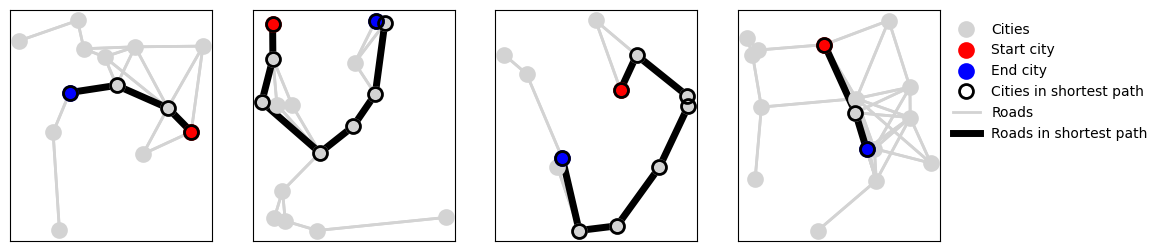

In [5]:
#@title Visualizing the task. { form-width: "30%" }
generator = task_graph_generator(
    random_seed=0, num_nodes_min_max=(9, 17), theta=20)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax in axes.flatten():
  task_graph = next(generator)
  draw_graph(ax, task_graph)
axes[-1].legend(loc="upper left", bbox_to_anchor=[1., 1.], frameon=False)

print(task_graph)
print("cities", task_graph.node_sets["cities"].spec)
print("roads", task_graph.edge_sets["roads"].spec)

In [6]:
# @title Build utils to convert back and forth between task graph, and graph the hidden state.  { form-width: "30%" }

# Initial hidden states can be set up with MapFeatures as follows.

def _set_initial_node_state(cities_set, *, node_set_name):
  assert node_set_name == "cities"
  return tf.concat(
      [tf.cast(cities_set["weight"], tf.float32)[..., None],
       tf.cast(cities_set["is_start"], tf.float32)[..., None],
       tf.cast(cities_set["is_end"], tf.float32)[..., None],
       # Don't provide the position for better generalization.
       # tf.cast(city_features["pos"], tf.float32),
       # Do not give the answer, unless debugging!
       # tf.cast(city_features["is_in_path"], tf.float32)[..., None],
       ],
      axis=-1)

def _set_initial_edge_state(road_set, *, edge_set_name):
  assert edge_set_name == "roads"
  return tf.concat(
      [tf.cast(road_set["weight"], tf.float32)[..., None],
       # Do not give the answer, unless debugging!
       # tf.cast(road_features["is_in_path"], tf.float32)[..., None],
       ],
      axis=-1)

def _set_initial_context_state(context):
  return tfgnn.keras.layers.MakeEmptyFeature()(context)

build_initial_hidden_state = tfgnn.keras.layers.MapFeatures(
      node_sets_fn=_set_initial_node_state,
      edge_sets_fn=_set_initial_edge_state,
      context_fn=_set_initial_context_state)


# Final predictions can often just be read out of the GraphTensor. This colab
# copies them back from the network's output into the input GraphTensor, so that
# consumers of shortest paths (e.g., `draw_graph()`) can be agnostic of whether
# the shortest path is a prediction or a label.
# TODO(b/234563300): Consider supporting `MapFeatures` for multiple graphs,
# to express feature copying with that.

def predict_from_final_hidden_state(task_graph, output_graph):
  """Transforms output logits into "is_in_path" prediction."""

  city_features = task_graph.node_sets["cities"].get_features_dict()
  node_logits = output_graph.node_sets["cities"][
      tfgnn.HIDDEN_STATE]
  city_features["is_in_path"] = tf.cast(
      tf.argmax(node_logits, axis=-1), tf.bool)

  road_features = task_graph.edge_sets["roads"].get_features_dict()
  edge_logits = output_graph.edge_sets["roads"][
      tfgnn.HIDDEN_STATE]
  road_features["is_in_path"] = tf.cast(
      tf.argmax(edge_logits, axis=-1), tf.bool)

  return task_graph.replace_features(
      node_sets={"cities": city_features},
      edge_sets={"roads": road_features})

In [7]:
# @title Build dataset, model and optimizer, inspecting variables. { form-width: "30%" }
tf.keras.backend.clear_session()

task_dataset = get_dataset(random_seed=0, num_nodes_min_max=(8, 17), theta=20)
trainable_gnn = EncodeProcessDecode(
    edge_output_size=2,  # Binary edge classification.
    node_output_size=2,  # Binary node classification.
    context_output_size=None,  # Don't need this output.
    # Other configurable hyperparameters (most combinations should train).
    num_message_passing_steps=12,
    num_mlp_hidden_layers=2,
    mlp_hidden_size=128,
    latent_size=128,
    use_layer_norm=True,
    shared_processors=False,
    )
optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1500,
        decay_rate=0.1),
    )

# For plotting learning curves.
steps_curve = []
losses_curve = []
accuracies_curve = []

# Call the model once to inspect all of the variables.
task_graph = next(iter(task_dataset))
trainable_gnn(build_initial_hidden_state(task_graph))
for var in trainable_gnn.variables:
  print(var.name, var.shape, var.dtype)

encode_process_decode/encoder/context/dense_0/kernel:0 (0, 128) <dtype: 'float32'>
encode_process_decode/encoder/context/dense_0/bias:0 (128,) <dtype: 'float32'>
encode_process_decode/encoder/context/dense_1/kernel:0 (128, 128) <dtype: 'float32'>
encode_process_decode/encoder/context/dense_1/bias:0 (128,) <dtype: 'float32'>
encode_process_decode/encoder/context/dense_2/kernel:0 (128, 128) <dtype: 'float32'>
encode_process_decode/encoder/context/dense_2/bias:0 (128,) <dtype: 'float32'>
encode_process_decode/encoder/context/layer_norm/gamma:0 (128,) <dtype: 'float32'>
encode_process_decode/encoder/context/layer_norm/beta:0 (128,) <dtype: 'float32'>
encode_process_decode/encoder/nodes_cities/dense_0/kernel:0 (3, 128) <dtype: 'float32'>
encode_process_decode/encoder/nodes_cities/dense_0/bias:0 (128,) <dtype: 'float32'>
encode_process_decode/encoder/nodes_cities/dense_1/kernel:0 (128, 128) <dtype: 'float32'>
encode_process_decode/encoder/nodes_cities/dense_1/bias:0 (128,) <dtype: 'float32'>

In [8]:
# @title Build loss and update fn.  { form-width: "30%" }

def loss_fn(task_graph):
  """Build loss, and accuracy functions."""

  # Run forward pass and get logits.
  input_graph = build_initial_hidden_state(task_graph)
  output_graph = trainable_gnn(input_graph)

  node_logits = output_graph.node_sets["cities"][
      tfgnn.HIDDEN_STATE]
  edge_logits = output_graph.edge_sets["roads"][
      tfgnn.HIDDEN_STATE]

  # Get ground truth labels.
  node_labels = tf.cast(
      task_graph.node_sets["cities"]["is_in_path"], tf.int64)
  edge_labels = tf.cast(
      task_graph.edge_sets["roads"]["is_in_path"], tf.int64)

  # Simultaneously optimize the edge an node classification problem.
  losses = {
      "edges": tf.nn.sparse_softmax_cross_entropy_with_logits(
          edge_labels, edge_logits),
      "nodes": tf.nn.sparse_softmax_cross_entropy_with_logits(
          node_labels, node_logits),
  }

  # We will also track the prediction accuracy.
  predicted_graph = predict_from_final_hidden_state(task_graph, output_graph)
  predicted_node_labels = tf.cast(
      predicted_graph.node_sets["cities"]["is_in_path"], tf.int64)
  predicted_edge_labels = tf.cast(
      predicted_graph.edge_sets["roads"]["is_in_path"], tf.int64)
  accuracy = {
      "edges": tf.cast(
          node_labels == predicted_node_labels, tf.float32),
      "nodes": tf.cast(
          edge_labels == predicted_edge_labels, tf.float32),
  }

  return tf.nest.map_structure(tf.reduce_mean, (losses, accuracy))


def update_step(task_graph):
  """Step of optimization of the loss."""
  with tf.GradientTape() as g:
    losses, accuracies = loss_fn(task_graph)
  grads = g.gradient(losses, trainable_gnn.variables)
  apply_op = optimizer.apply_gradients(zip(grads, trainable_gnn.variables))
  with tf.control_dependencies([apply_op]):
    return tf.nest.map_structure(tf.identity, (losses, accuracies))

In [9]:
# @title Run training (can be interrupted and continued).  { form-width: "30%" }

NUM_ITERATIONS = 2000
TRAIN_BATCH_SIZE = 64

ds = task_dataset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)
ds = ds.map(lambda x: x.merge_batch_to_components())

update_step_compiled = tf.function(update_step, input_signature=(ds.element_spec,))

try:
  for batch in ds:
    iteration = optimizer.iterations.numpy()
    if iteration >= NUM_ITERATIONS:
      break
    losses, accuracies = update_step_compiled(batch)
    steps_curve.append(iteration)
    losses_curve.append(losses)
    accuracies_curve.append(accuracies)
    if iteration % 10 == 0:
      print(f"Iteration {iteration}. "
            f"Losses {nest_to_numpy(losses)}. "
            f"Accuracies {nest_to_numpy(accuracies)}")
except KeyboardInterrupt:
  pass

Iteration 0. Losses {'edges': 2.761656, 'nodes': 0.8019268}. Accuracies {'edges': 0.37533876, 'nodes': 0.09136364}
Iteration 10. Losses {'edges': 0.32634243, 'nodes': 0.73445225}. Accuracies {'edges': 0.46816975, 'nodes': 0.9015817}
Iteration 20. Losses {'edges': 0.2873109, 'nodes': 0.50726295}. Accuracies {'edges': 0.768021, 'nodes': 0.9047619}
Iteration 30. Losses {'edges': 0.25963867, 'nodes': 0.48964927}. Accuracies {'edges': 0.8013072, 'nodes': 0.914298}
Iteration 40. Losses {'edges': 0.231912, 'nodes': 0.4294098}. Accuracies {'edges': 0.8297587, 'nodes': 0.9222942}
Iteration 50. Losses {'edges': 0.19581689, 'nodes': 0.38189906}. Accuracies {'edges': 0.8346253, 'nodes': 0.9339775}
Iteration 60. Losses {'edges': 0.19011466, 'nodes': 0.37113708}. Accuracies {'edges': 0.83919597, 'nodes': 0.93687063}
Iteration 70. Losses {'edges': 0.23999102, 'nodes': 0.40276325}. Accuracies {'edges': 0.7950066, 'nodes': 0.91421145}
Iteration 80. Losses {'edges': 0.22221853, 'nodes': 0.44544998}. Acc

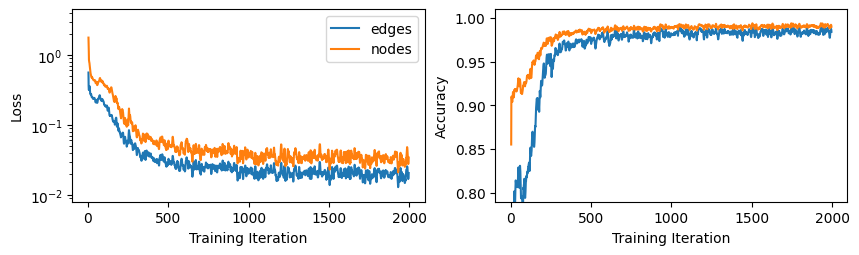

In [11]:
# @title Plot learning curves. { form-width: "30%" }

smoooth_window_half_width = 3

fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))
for ax, metric, data_list in zip(
    axes, ["Loss", "Accuracy"], [losses_curve, accuracies_curve]):
  for k in ["edges", "nodes"]:
    x = steps_curve
    y = [d[k] for d in data_list]

    window = signal.windows.triang(1 + 2 * smoooth_window_half_width)
    window /= window.sum()
    y = signal.convolve(y, window, mode="valid")
    x = x[smoooth_window_half_width:-smoooth_window_half_width]
    ax.plot(x, y, label=k)
  ax.set_ylabel(metric)
  ax.set_xlabel("Training Iteration")

axes[0].set_yscale("log")
axes[0].set_ylim(0.00801, 4.5)
axes[1].set_ylim(0.79, 1.01)
axes[0].legend()

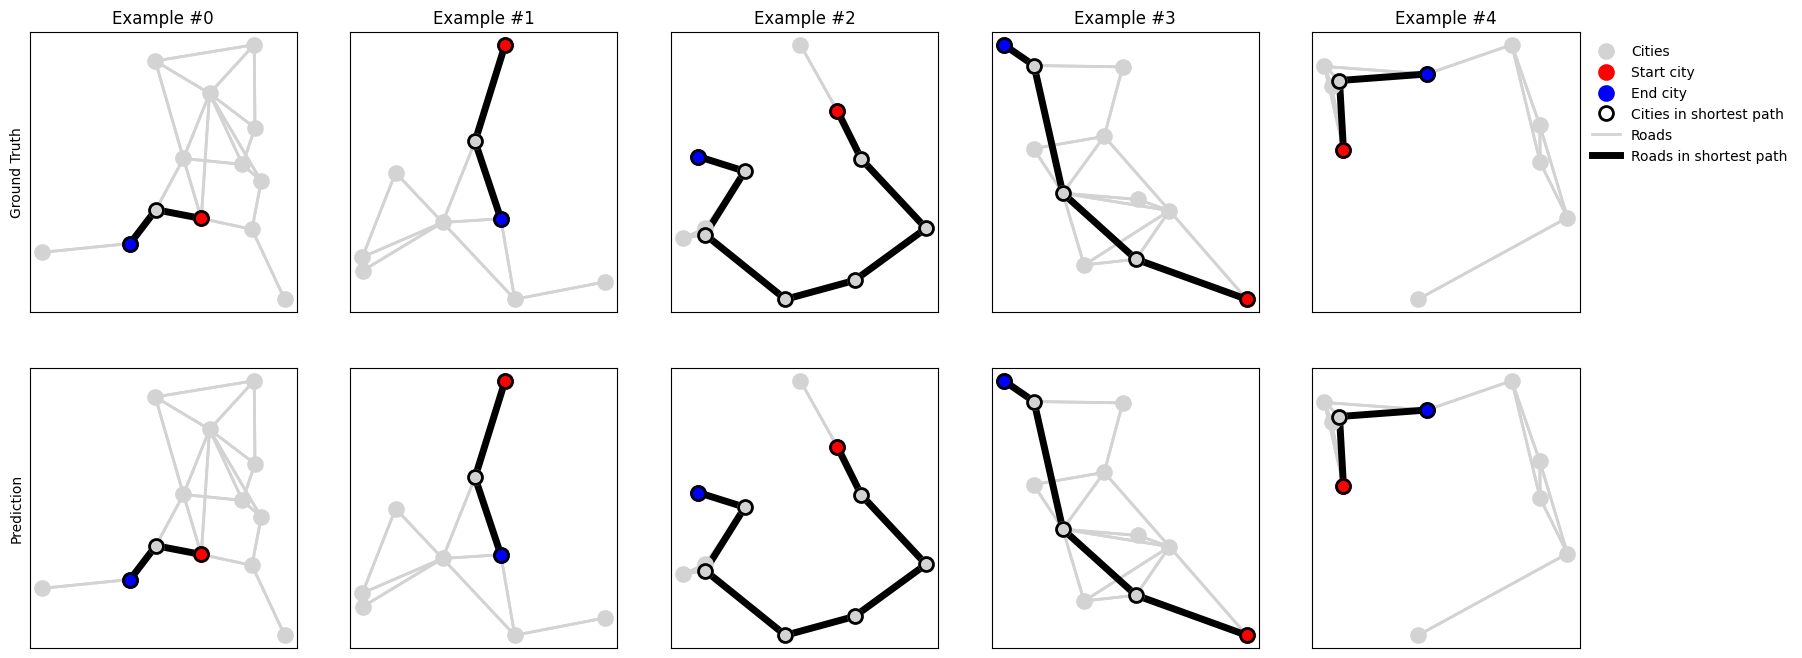

In [12]:
# @title Visualize model predictions. { form-width: "30%" }

iterator = iter(task_dataset.take(5))
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for example_i, task_graph in enumerate(iterator):
  input_graph = build_initial_hidden_state(task_graph)
  output_graph = trainable_gnn(input_graph)

  predicted_task_graph = predict_from_final_hidden_state(
      task_graph, output_graph)
  axes[0, example_i].set_title(f"Example #{example_i}")
  draw_graph(axes[0, example_i], task_graph)
  draw_graph(axes[1, example_i], predicted_task_graph)

axes[0, 0].set_ylabel("Ground Truth")
axes[1, 0].set_ylabel("Prediction")
axes[0, -1].legend(loc="upper left", bbox_to_anchor=[1., 1.], frameon=False)